In [40]:
import torch.nn as nn
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [2]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')


In [105]:
encoded = tokenizer(['I am an undergraduated', 
                     'my name is dongryul. how are you today?',
                     'I`m from korea. where r u from?',
                     'do you like bibimbab?'], return_tensors='pt', padding=True)
print(encoded)

{'input_ids': tensor([[  101,  1045,  2572,  2019,  8324,  2094,   102,     0,     0,     0,
             0,     0,     0,     0],
        [  101,  2026,  2171,  2003, 11947,  2854,  5313,  1012,  2129,  2024,
          2017,  2651,  1029,   102],
        [  101,  1045,  1036,  1049,  2013,  4420,  1012,  2073,  1054,  1057,
          2013,  1029,   102,     0],
        [  101,  2079,  2017,  2066, 12170,  5638, 11201,  2497,  1029,   102,
             0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]])}


In [106]:
input_ids = encoded['input_ids']
attention_mask = encoded['attention_mask']
print('input_ids : \n{}'.format(input_ids))
print('attention_mask : \n{}'.format(attention_mask))

input_ids : 
tensor([[  101,  1045,  2572,  2019,  8324,  2094,   102,     0,     0,     0,
             0,     0,     0,     0],
        [  101,  2026,  2171,  2003, 11947,  2854,  5313,  1012,  2129,  2024,
          2017,  2651,  1029,   102],
        [  101,  1045,  1036,  1049,  2013,  4420,  1012,  2073,  1054,  1057,
          2013,  1029,   102,     0],
        [  101,  2079,  2017,  2066, 12170,  5638, 11201,  2497,  1029,   102,
             0,     0,     0,     0]])
attention_mask : 
tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]])


In [211]:
padding_mask = attention_mask
mask = padding_mask.unsqueeze(1) # [bs, 1, seq_len]
mask.shape, mask

(torch.Size([4, 1, 14]),
 tensor([[[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]],
 
         [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
 
         [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]],
 
         [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]]]))

In [212]:
input_ids.masked_fill(attention_mask == 0, -1e9)

tensor([[        101,        1045,        2572,        2019,        8324,
                2094,         102, -1000000000, -1000000000, -1000000000,
         -1000000000, -1000000000, -1000000000, -1000000000],
        [        101,        2026,        2171,        2003,       11947,
                2854,        5313,        1012,        2129,        2024,
                2017,        2651,        1029,         102],
        [        101,        1045,        1036,        1049,        2013,
                4420,        1012,        2073,        1054,        1057,
                2013,        1029,         102, -1000000000],
        [        101,        2079,        2017,        2066,       12170,
                5638,       11201,        2497,        1029,         102,
         -1000000000, -1000000000, -1000000000, -1000000000]])

In [213]:
# Define Embedding & Softmax 
embedding = nn.Embedding(30000, 8, padding_idx=0)
softmax = nn.Softmax(dim=-1)

In [214]:
# shape
print('input_ids shape : {}'.format(input_ids.shape))
print('attention_mask shape : {}'.format(attention_mask.shape))
print('mask shape : {}'.format(mask.shape))

input_ids shape : torch.Size([4, 14])
attention_mask shape : torch.Size([4, 14])
mask shape : torch.Size([4, 1, 14])


In [215]:
emb_input_ids = embedding(input_ids)
print('emb_input_ids shape : {}'.format(emb_input_ids.shape)) # batch * seq * hidden_size(feature dimension)

emb_input_ids shape : torch.Size([4, 14, 8])


In [216]:
energy = emb_input_ids.matmul(emb_input_ids.transpose(-1, -2))
print('energy shape : {}'.format(energy.shape)) # batch * seq * seq

energy shape : torch.Size([4, 14, 14])


In [217]:
d_k = emb_input_ids.size(-1)**(1/2)
energy = energy / d_k
print('energy shape : {}'.format(energy.shape)) # batch * seq * seq

energy shape : torch.Size([4, 14, 14])


In [218]:
bs = energy.size(0)
max_seq_len = energy.size(1)
dim = energy.size(2)
with_causal_mask = True
if with_causal_mask:
    causal_mask = torch.tril(torch.ones(bs, max_seq_len, dim, dtype=int))
    print('causal_mask shape : {}'.format(causal_mask.shape))
else:
    causal_mask = None
    print('causal_mask is None')
print('batch size : {}'.format(bs))
print('max sequence length : {}'.format(max_seq_len))
print('feature dimension : {}'.format(dim))

causal_mask shape : torch.Size([4, 14, 14])
batch size : 4
max sequence length : 14
feature dimension : 14


In [219]:
if causal_mask is not None:
    mask = mask * causal_mask

energy = energy.masked_fill(mask == 0, -1e9)
print('energy shape : {}'.format(energy.shape)) # batch * seq * seq

energy shape : torch.Size([4, 14, 14])


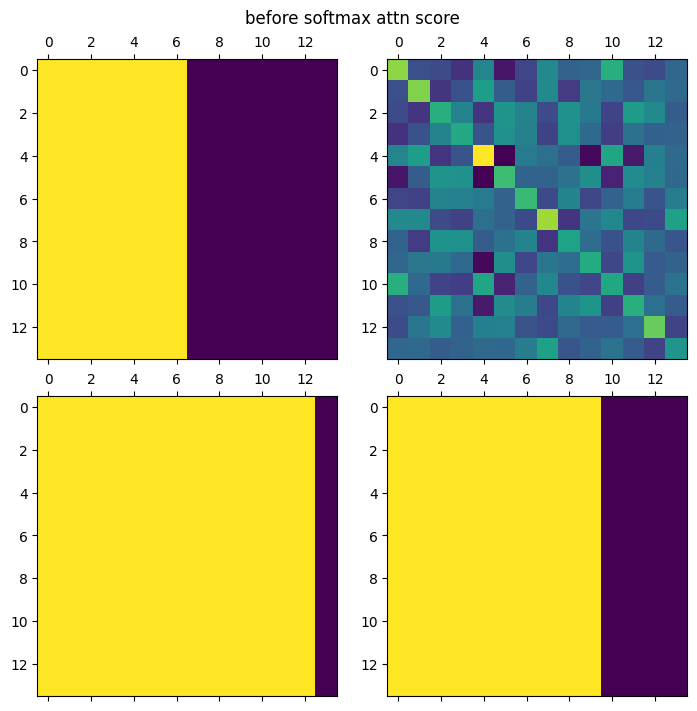

In [206]:
if not with_causal_mask:
    fig, axs = plt.subplots(2, 2, figsize=(7, 7), layout='constrained')

    ax1 = axs[0][0]
    ax1.matshow(energy[0].detach().numpy())

    ax2 = axs[0][1]
    ax2.matshow(energy[1].detach().numpy())

    ax3 = axs[1][0]
    ax3.matshow(energy[2].detach().numpy())

    ax4 = axs[1][1]
    ax4.matshow(energy[3].detach().numpy())

    plt.suptitle('before softmax attn score')
    plt.show()

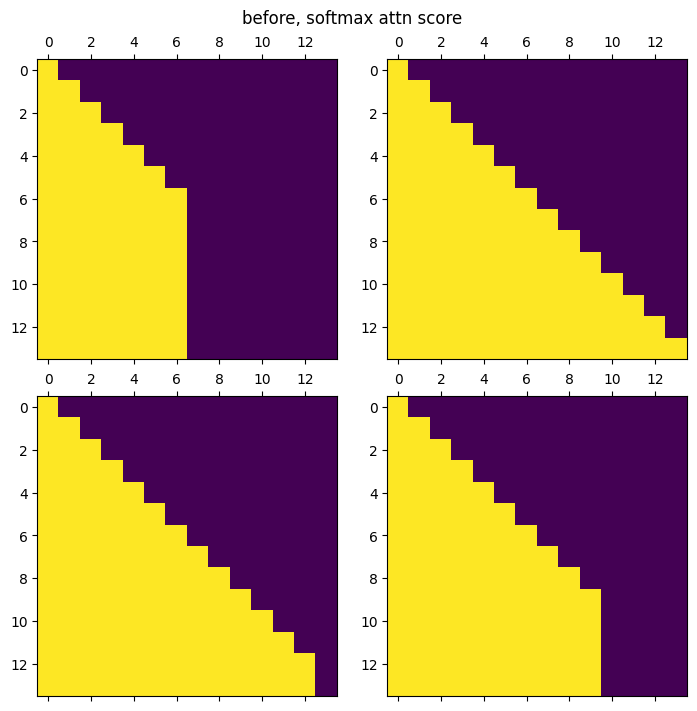

In [220]:
if with_causal_mask:
    fig, axs = plt.subplots(2, 2, figsize=(7, 7), layout='constrained')

    ax1 = axs[0][0]
    ax1.matshow(energy[0].detach().numpy())

    ax2 = axs[0][1]
    ax2.matshow(energy[1].detach().numpy())

    ax3 = axs[1][0]
    ax3.matshow(energy[2].detach().numpy())

    ax4 = axs[1][1]
    ax4.matshow(energy[3].detach().numpy())

    plt.suptitle('before, softmax attn score')
    plt.show()

In [221]:
output = softmax(energy)
print('output shape : {}'.format(output.shape)) # batch * seq * seq

output shape : torch.Size([4, 14, 14])


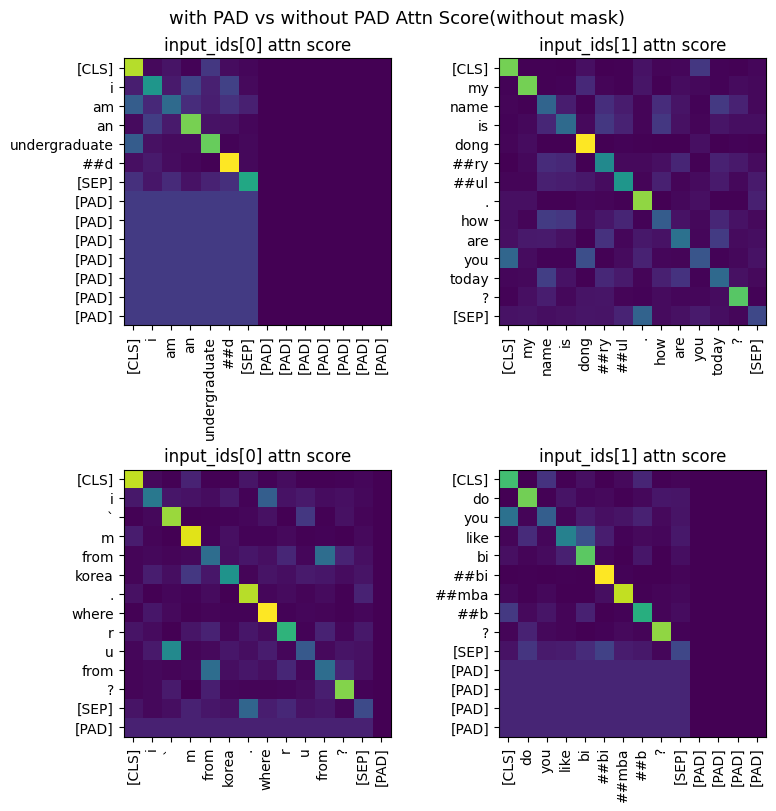

In [209]:
if not with_causal_mask:
    fig, axs = plt.subplots(2, 2, figsize=(8, 8), layout='constrained')

    ax1 = axs[0][0]
    sc = ax1.matshow(output[0][:].detach().numpy())
    ax1.set_xticks(range(input_ids.size(-1)), 
                   tokenizer.batch_decode(input_ids[0]), 
                   rotation=90)
    ax1.set_yticks(range(input_ids.size(-1)), 
                   tokenizer.batch_decode(input_ids[0]))
    ax1.set_title('input_ids[0] attn score')
    ax1.xaxis.tick_bottom()

    ax2 = axs[0][1]
    ax2.matshow(output[1].detach().numpy())
    ax2.set_xticks(range(input_ids.size(-1)), 
                   tokenizer.batch_decode(input_ids[1]),
                   rotation=90)
    ax2.set_yticks(range(input_ids.size(-1)), 
                   tokenizer.batch_decode(input_ids[1]))
    ax2.set_title('input_ids[1] attn score')
    ax2.xaxis.tick_bottom()

    ax3 = axs[1][0]
    ax3.matshow(output[2].detach().numpy())
    ax3.set_xticks(range(input_ids.size(-1)), 
                   tokenizer.batch_decode(input_ids[2]), 
                   rotation=90)
    ax3.set_yticks(range(input_ids.size(-1)), 
                   tokenizer.batch_decode(input_ids[2]))
    ax3.set_title('input_ids[3] attn score')
    ax3.xaxis.tick_bottom()

    ax4 = axs[1][1]
    ax4.matshow(output[3].detach().numpy())
    ax4.set_xticks(range(input_ids.size(-1)), 
                   tokenizer.batch_decode(input_ids[3]),
                   rotation=90)
    ax4.set_yticks(range(input_ids.size(-1)), 
                   tokenizer.batch_decode(input_ids[3]))
    ax4.set_title('input_ids[4] attn score')
    ax4.xaxis.tick_bottom()

    plt.suptitle('with PAD vs without PAD Attn Score(without mask)', fontsize=13)
    plt.show()

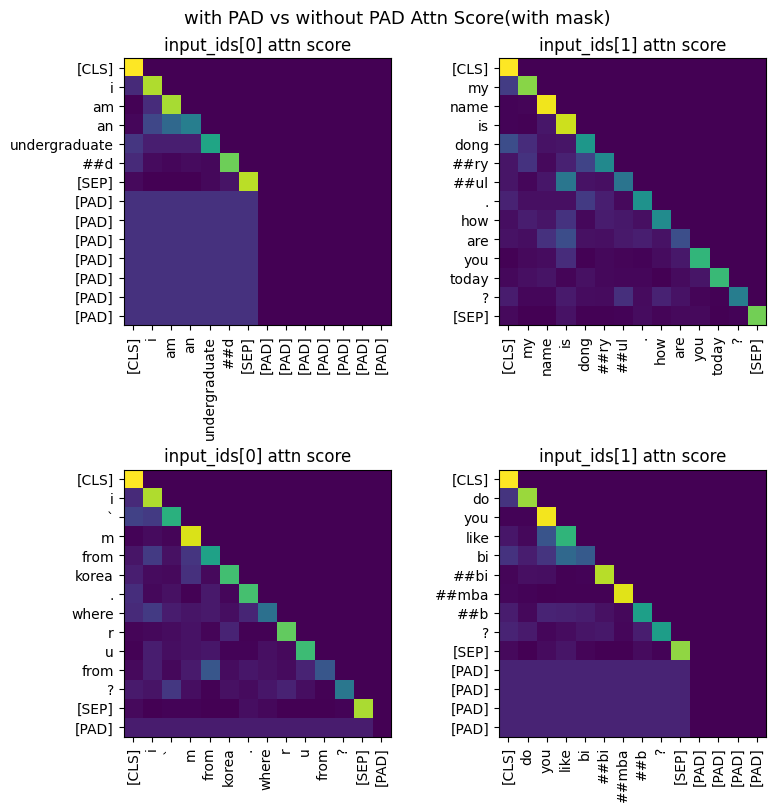

In [222]:
if with_causal_mask:
    fig, axs = plt.subplots(2, 2, figsize=(8, 8), layout='constrained')

    ax1 = axs[0][0]
    sc = ax1.matshow(output[0][:].detach().numpy())
    ax1.set_xticks(range(input_ids.size(-1)), 
                   tokenizer.batch_decode(input_ids[0]), 
                   rotation=90)
    ax1.set_yticks(range(input_ids.size(-1)), 
                   tokenizer.batch_decode(input_ids[0]))
    ax1.set_title('input_ids[0] attn score')
    ax1.xaxis.tick_bottom()

    ax2 = axs[0][1]
    ax2.matshow(output[1].detach().numpy())
    ax2.set_xticks(range(input_ids.size(-1)), 
                   tokenizer.batch_decode(input_ids[1]),
                   rotation=90)
    ax2.set_yticks(range(input_ids.size(-1)), 
                   tokenizer.batch_decode(input_ids[1]))
    ax2.set_title('input_ids[1] attn score')
    ax2.xaxis.tick_bottom()

    ax3 = axs[1][0]
    ax3.matshow(output[2].detach().numpy())
    ax3.set_xticks(range(input_ids.size(-1)), 
                   tokenizer.batch_decode(input_ids[2]), 
                   rotation=90)
    ax3.set_yticks(range(input_ids.size(-1)), 
                   tokenizer.batch_decode(input_ids[2]))
    ax3.set_title('input_ids[3] attn score')
    ax3.xaxis.tick_bottom()

    ax4 = axs[1][1]
    ax4.matshow(output[3].detach().numpy())
    ax4.set_xticks(range(input_ids.size(-1)), 
                   tokenizer.batch_decode(input_ids[3]),
                   rotation=90)
    ax4.set_yticks(range(input_ids.size(-1)), 
                   tokenizer.batch_decode(input_ids[3]))
    ax4.set_title('input_ids[4] attn score')
    ax4.xaxis.tick_bottom()

    plt.suptitle('with PAD vs without PAD Attn Score(with mask)', fontsize=13)
    plt.show()

In [223]:
result = output.matmul(emb_input_ids)
print('result shape : {}'.format(result.shape))

result shape : torch.Size([4, 14, 8])
